<a href="https://colab.research.google.com/github/Joshua250304/JPMC-Research-Project/blob/main/Loan_Default_Risk_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

print("Please upload the 'Loan_Data.csv' file.")
uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

# To verify the file is uploaded, you can list the files in the current directory
# !ls

Please upload the 'Loan_Data.csv' file.


Saving Loan_Data.csv to Loan_Data.csv
User uploaded file "Loan_Data.csv" with length 546807 bytes


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

data = pd.read_csv('Loan_Data.csv')  # Load data from a CSV file
data.head()
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


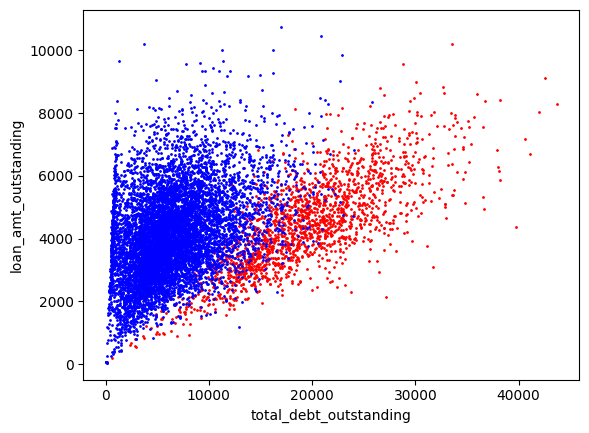

In [ ]:
plt.clf()  # Clear any previous plots
plt.xlabel('total_debt_outstanding')
plt.ylabel('loan_amt_outstanding')

plt.scatter(data[data['default'] == 1]['total_debt_outstanding'], data[data['default'] == 1]['loan_amt_outstanding'], c='r', s=1)
plt.scatter(data[data['default'] == 0]['total_debt_outstanding'], data[data['default'] == 0]['loan_amt_outstanding'], c='b', s=1)
plt.show()


In [ ]:
data['debt_to_loan'] = data['total_debt_outstanding'] / data['loan_amt_outstanding']
data['debt_to_income'] = data['total_debt_outstanding'] / data['income']
print(data)

      customer_id  credit_lines_outstanding  loan_amt_outstanding  \
0         8153374                         0           5221.545193   
1         7442532                         5           1958.928726   
2         2256073                         0           3363.009259   
3         4885975                         0           4766.648001   
4         4700614                         1           1345.827718   
...           ...                       ...                   ...   
9995      3972488                         0           3033.647103   
9996      6184073                         1           4146.239304   
9997      6694516                         2           3088.223727   
9998      3942961                         0           3288.901666   
9999      5533570                         1           1917.652480   

      total_debt_outstanding       income  years_employed  fico_score  \
0                3915.471226  78039.38546               5         605   
1                8228.752

In [ ]:
debt_to_loan_defaulted = data[data['default'] == 1]['debt_to_loan'].mean()
debt_to_loan_notdefaulted = data[data['default'] == 0]['debt_to_loan'].mean()

debt_to_income_defaulted = data[data['default'] == 1]['debt_to_income'].mean()
debt_to_income_notdefaulted = data[data['default'] == 0]['debt_to_income'].mean()

print(debt_to_loan_defaulted, debt_to_loan_notdefaulted, debt_to_income_defaulted, debt_to_income_notdefaulted)

4.445373757444491 1.6006943643749982 0.272104678726068 0.0903809375257615


In [ ]:
print(data[data['default'] == 1].describe())

        customer_id  credit_lines_outstanding  loan_amt_outstanding  \
count  1.851000e+03               1851.000000           1851.000000   
mean   5.007914e+06                  4.618044           4454.854897   
std    2.278015e+06                  0.637969           1471.586769   
min    1.000324e+06                  2.000000            189.725024   
25%    3.016468e+06                  4.000000           3395.163895   
50%    5.116813e+06                  5.000000           4393.697084   
75%    6.972913e+06                  5.000000           5388.006613   
max    8.989969e+06                  5.000000          10210.746690   

       total_debt_outstanding         income  years_employed   fico_score  \
count             1851.000000    1851.000000     1851.000000  1851.000000   
mean             19270.582961   70726.740140        3.617504   596.257699   
std               6298.378378   20363.512385        1.401002    58.949929   
min                592.445977    2836.241899        

In [ ]:
features = ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score', 'debt_to_loan', 'debt_to_income']

df = data.copy()
y = df['default']  # Target variable
X = df[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_model = LogisticRegression(max_iter=10000)
decision_tree_model = DecisionTreeClassifier()
logistic_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)


logistic_predictions_balanced = logistic_model.predict_proba(X_test)[:, 1]
tree_predictions_balanced = decision_tree_model.predict_proba(X_test)[:, 1]
logistic_auc_balanced = roc_auc_score(y_test, logistic_predictions_balanced)
tree_auc_balanced = roc_auc_score(y_test, tree_predictions_balanced)

print(logistic_auc_balanced, tree_auc_balanced)

0.9999721688792408 0.986613230914809


In [ ]:
def calculate_expected_loss(model, features, loan_amount, recovery_rate=0.10):
    """
    Calculate expected loss for a loan based on the probability of default and recovery rate.

    Parameters:
    - model: Trained machine learning model for default prediction.
    - features: DataFrame or array-like, features of the loan.
    - loan_amount: float, the outstanding amount of the loan.
    - recovery_rate: float, the expected recovery rate in the event of a default.

    Returns:
    - expected_loss: float, the expected monetary loss on the loan.
    """
    probability_of_default = model.predict_proba(features)[:, 1]  # Predict the probability of default
    expected_loss = probability_of_default * (1 - recovery_rate) * loan_amount  # Calculate expected loss
    return expected_loss

In [ ]:
test_loan_features = pd.DataFrame([{
    'credit_lines_outstanding': 3,
    'loan_amt_outstanding': 5000,  # $5,000 loan
    'total_debt_outstanding': 7500,  # Total debt $7,500
    'income': 55000,  # Annual income $55,000
    'years_employed': 4,
    'fico_score': 610,
    'debt_to_loan': 1.5,
    'debt_to_income': 0.15
}])
expected_loss_example = calculate_expected_loss(logistic_model, test_loan_features, 5000)
print(f'Expected loss is: ${round(expected_loss_example[-1],2)}')

Expected loss is: $43.09
